In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, LSTM,GRU
from tensorflow import keras

In [21]:
data = pd.read_csv("D:\\học đại học\\20222\\machine learning\\data.csv")

In [22]:
time=data['Date']
data=data.drop(['Date','BTC_change'], axis=1)

target="BTC_close"

In [23]:
data.head()

,BTC_close,BTC_open,BTC_high,BTC_low,difficulty,addresses_active_count,sum_lock_weight,mean_lock_size_ytes,total_fees_usd,mean_hash_rate,...,ETH,LTC,XRP,DOGE,COPPER,GOLD,SILVER,SPX,JP225,DJI
0,29890.5,29992.8,30497.8,29590.4,52350439455487,1000988,547153915,1.650655e+06,1.292778e+06,3.565226e+08,...,1872.32,85.97,0.49401,0.065567,3.8900,1923.70,22.467,4381.89,33445.0,34210.0
1,29996.9,28307.7,30769.5,28270.5,52350439455487,920555,483181576,1.611773e+06,1.347976e+06,3.148849e+08,...,1889.87,85.12,0.49995,0.065644,3.9135,1944.90,22.810,4365.69,33390.0,34235.0
2,28307.7,26845.9,28393.0,26665.5,52350439455487,951926,543133484,1.677592e+06,1.052364e+06,3.539202e+08,...,1791.61,80.31,0.49270,0.063108,3.8835,1947.70,23.234,4388.71,33155.0,34356.0
3,26845.9,26339.7,27029.7,26295.1,52350439455487,920552,567091224,1.758290e+06,8.514319e+05,3.695343e+08,...,1737.06,77.51,0.49341,0.062429,3.8643,1964.05,24.062,0.00,0.0,0.0
4,26339.7,26515.0,26679.3,26290.6,52350439455487,883864,603064705,1.985675e+06,7.946708e+05,3.929555e+08,...,1720.98,77.20,0.48699,0.062107,3.8738,1969.45,24.198,0.00,0.0,0.0


In [24]:
target=np.array(target)
target.shape

()

In [25]:
train_data= data.copy().iloc[:int(0.7*len(data)),:]
train_np= train_data.to_numpy()
val_data=data.copy().iloc[int(0.7*len(data)):int(0.85*len(data)),:]
val_np=val_data.to_numpy()
test_data=data.copy().iloc[int(0.85*len(data)):,:]
test_np=test_data.to_numpy()

In [26]:
train_np = np.asarray(train_np).astype('float32')
val_np = np.asarray(val_np).astype('float32')
test_np = np.asarray(test_np).astype('float32')

In [27]:
time_step=30
train_time_line=[]
val_time_line=[]
test_time_line=[]

In [28]:
def scale_sequence_data(df,timesteps ,close_col_idx):
    x = []
    y = []
    timeLine=[]
    for i in range(len(df)-timesteps):    
        scaler=MinMaxScaler()      
        scaler.fit(df[i:i+timesteps,:])
        timeLine.append((scaler.data_min_[close_col_idx],scaler.data_max_[close_col_idx]))
        x.append(scaler.transform(df[i:i+timesteps,:]))
        value=df[i+timesteps].reshape(1,-1)
        value=scaler.transform(value)
        y.append(value[:,close_col_idx])

    return np.array(x),np.array(y),timeLine


In [29]:
train_x, train_y,train_time_line = scale_sequence_data(train_np, time_step,data.columns.get_loc('BTC_close'))
val_x,val_y,val_time_line =scale_sequence_data(val_np,time_step ,data.columns.get_loc('BTC_close'))
test_x, test_y,test_time_line = scale_sequence_data(test_np, time_step,data.columns.get_loc('BTC_close'))

In [39]:
model=Sequential()
model.add(GRU(units=128,return_sequences=True,recurrent_dropout=0.25))
model.add(GRU(units=128,return_sequences =True,recurrent_dropout=0.25))
model.add(GRU(units=64,return_sequences=False,recurrent_dropout=0.25))
model.add(Dense(1,activation='tanh'))
moniter=keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,  verbose=1,restore_best_weights=True)
model.compile(optimizer='adam',loss='MeanSquaredError')
model.fit(train_x,train_y,epochs=1, batch_size=32,validation_data=(val_x,val_y),callbacks=[moniter])
model.summary()

58/58 [==============================] - 40s 247ms/step - loss: 0.0797 - val_loss: 0.0251
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 30, 128)           58368     
                                                                 
 gru_7 (GRU)                 (None, 30, 128)           99072     
                                                                 
 gru_8 (GRU)                 (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 194753 (760.75 KB)
Trainable params: 194753 (760.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [40]:
model.compile(optimizer='adam',loss='MeanSquaredError')
model.fit(train_x,train_y,epochs=100, batch_size=32,validation_data=(val_x,val_y),callbacks=[moniter])

Epoch 1/100
58/58 [==============================] - 33s 203ms/step - loss: 0.0259 - val_loss: 0.0074
Epoch 2/100
58/58 [==============================] - 8s 137ms/step - loss: 0.0147 - val_loss: 0.0072
Epoch 3/100
58/58 [==============================] - 7s 115ms/step - loss: 0.0129 - val_loss: 0.0054
Epoch 4/100
58/58 [==============================] - 7s 128ms/step - loss: 0.0122 - val_loss: 0.0061
Epoch 5/100
58/58 [==============================] - 7s 123ms/step - loss: 0.0111 - val_loss: 0.0048
Epoch 6/100
58/58 [==============================] - 7s 119ms/step - loss: 0.0112 - val_loss: 0.0050
Epoch 7/100
58/58 [==============================] - 9s 159ms/step - loss: 0.0116 - val_loss: 0.0045
Epoch 8/100
58/58 [==============================] - 10s 166ms/step - loss: 0.0105 - val_loss: 0.0051
Epoch 9/100
58/58 [==============================] - 11s 196ms/step - loss: 0.0107 - val_loss: 0.0042
Epoch 10/100
58/58 [==============================] - 9s 154ms/step - loss: 0.0100 - val

In [41]:
model.evaluate(train_x,train_y)
model.evaluate(val_x,val_y)
model.evaluate(test_x,test_y)

12/12 [==============================] - 0s 22ms/step - loss: 0.0082


0.008198391646146774

In [42]:
predictions = model.predict(test_x)
test_y=test_y.reshape(-1,1)
prec_train=model.predict(train_x)
pre_val=model.predict(val_x)

12/12 [==============================] - 0s 17ms/step


In [43]:
def inverseTransform(value, timeline):
    result = []
    for i in range(len(timeline)):
        min_val = timeline[i][0]
        max_val = timeline[i][1]
        original_value = (value[i] * (max_val - min_val)) + min_val
        result.append(original_value)
    return np.array(result)

In [44]:
test_after_inverse=inverseTransform(predictions,test_time_line)
true_after_inverse=inverseTransform(test_y,test_time_line)
inverse_train_pred=inverseTransform(prec_train,train_time_line)
inverse_train_true=inverseTransform(train_y,train_time_line)

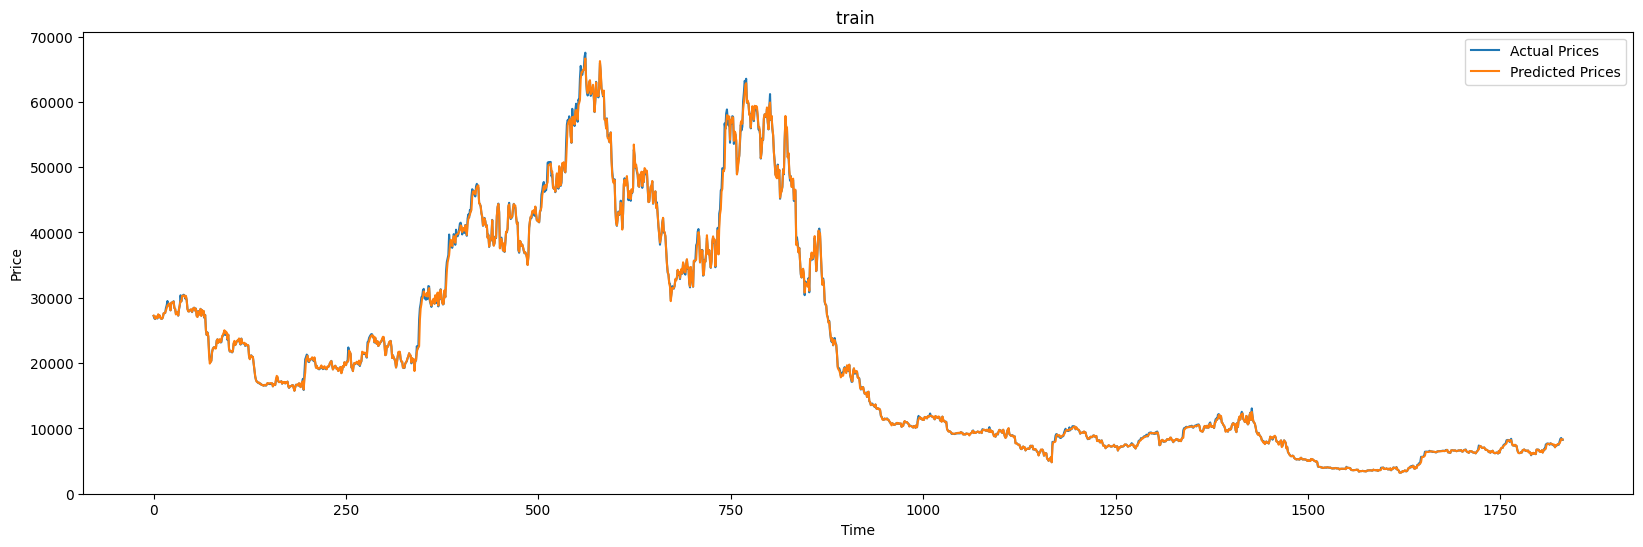

In [46]:
# Plot the predicted and actual prices
plt.figure(figsize=(20,6))
plt.plot(inverse_train_true, label='Actual Prices')
plt.plot(inverse_train_pred, label='Predicted Prices')

plt.title('train ')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

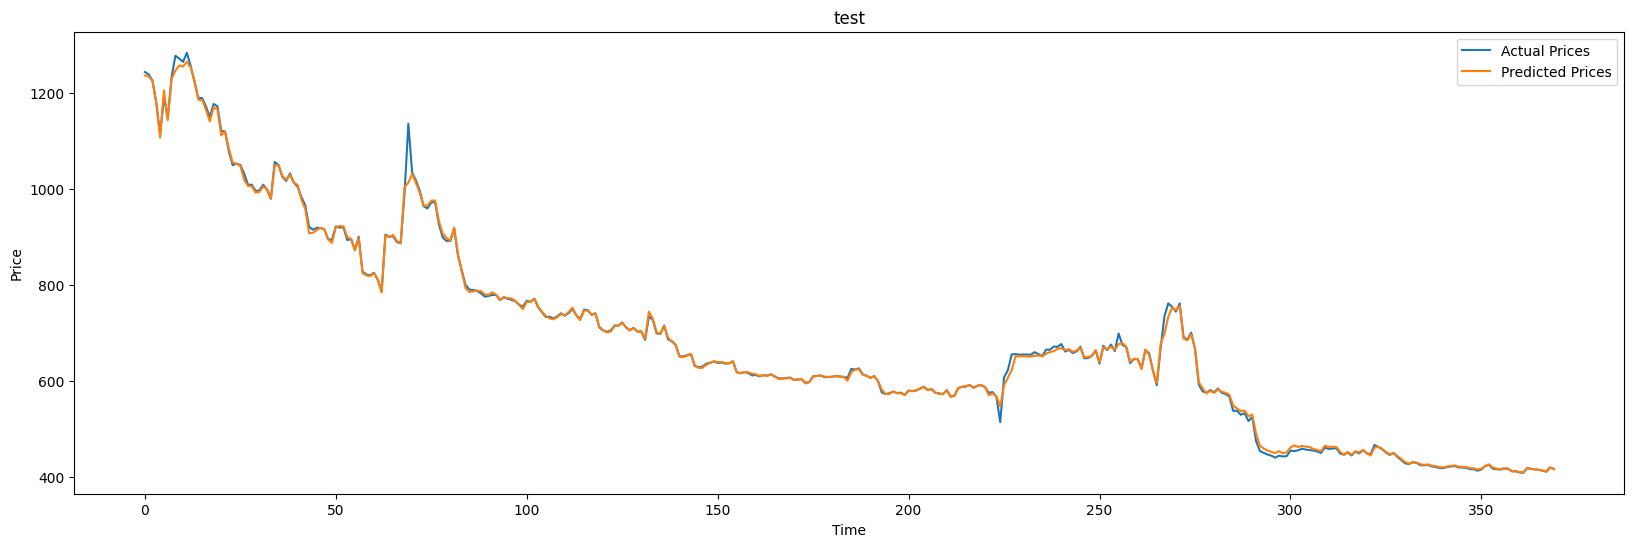

In [47]:
# Plot the predicted and actual prices
plt.figure(figsize=(20,6))
plt.plot(true_after_inverse, label='Actual Prices')
plt.plot(test_after_inverse, label='Predicted Prices')

plt.title('test')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:

true_train=inverse_train_true
prediction_train=inverse_train_pred
prediction_test=test_after_inverse
true_test=true_after_inverse    
def print_evaluation_results(true_values, predicted_values, dataset_name):
    print("Test ACCuracy for", dataset_name)
    print("------------------------------------------------------")
    # RMSE
    rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
    print("Root Mean Square Error (RMSE): {:.4f}".format(rmse))
    
    # MAPE
    mape = mean_absolute_percentage_error(true_values, predicted_values)
    print("Mean Absolute Percentage Error (MAPE): {:.4f}".format(mape))

# Print evaluation results for the train set
print_evaluation_results(true_train, prediction_train, "train set")

# Print evaluation results for the test set
print_evaluation_results(true_test, prediction_test, "test set")


Test ACCuracy for train set
------------------------------------------------------
Root Mean Square Error (RMSE): 368.9235
Mean Absolute Percentage Error (MAPE): 0.0056
Test ACCuracy for test set
------------------------------------------------------
Root Mean Square Error (RMSE): 8.5800
Mean Absolute Percentage Error (MAPE): 0.0051
